In [ ]:
# ..... metacells for each sample and MN ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)

In [7]:
# load data
currstage = 'stage21'
sc1 = readRDS(paste0(currstage, '_integrated_cca.rds'))

df1 = read.delim(paste0(currstage, '_metacell.csv'), sep = ',')
sc1$metacell = df1$metacell[match(rownames(sc1@meta.data), df1$barcode)]
sc1$stage <- sc1$orig.ident  

In [8]:
# make SCE object
sce = SingleCellExperiment(list(counts = sc1@assays$RNA@counts),
                           colData = DataFrame(sc1@meta.data))

options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$sample)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$metacell, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$metacell, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

topdf = topHits(aurocsall, dat = sce, study_id = sce$sample, cell_type = sce$metacell,
        threshold = 0.95)

# save
save(aurocs1v1, aurocsall, topdf, 
     file = paste0(currstage, '_metacell_MN_scores.Rdata'))

sample1A|1 sample1A|10 sample1A|101
sample1A|1   0.9953731  0.8398519   0.2134217   
sample1A|10  0.8398519  1.0000000   0.2474387   
sample1A|101 0.2134217  0.2474387   1.0000000

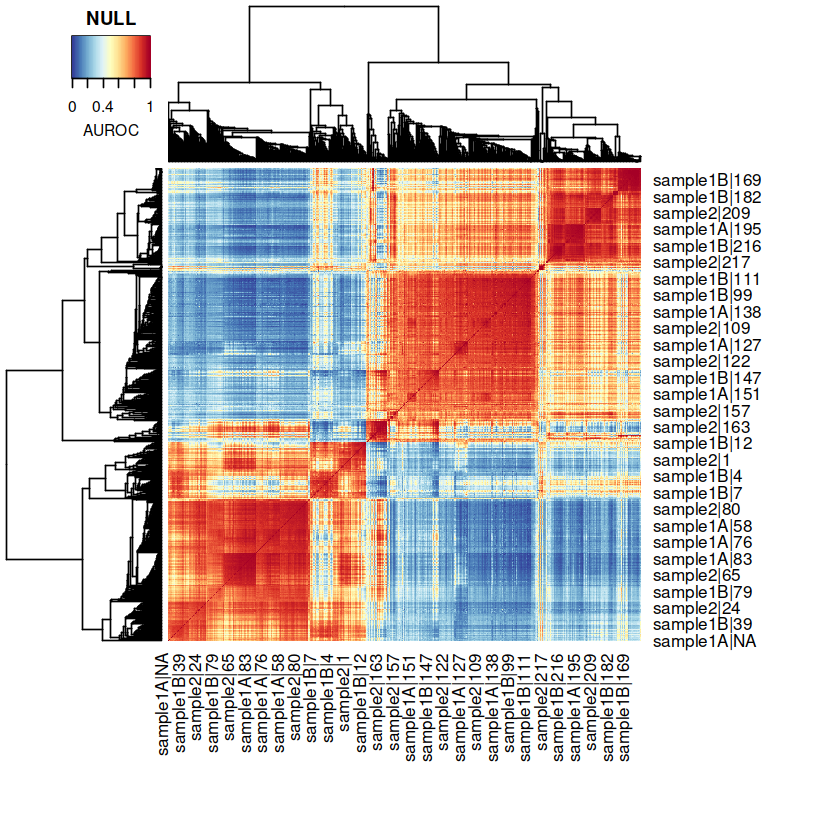

In [6]:
aurocsall[1:3,1:3]

# png(paste0('aa-', currstage, '_mc_MN.png'), width = 10, height = 10, res = 300, units = 'in')
plotHeatmap(aurocsall, margins = c(10,10))
# dev.off()

In [53]:
topdf = topHits(aurocsall, dat = sce, study_id = sce$sample, cell_type = sce$metacell,
        threshold = 0.95)
dim(topdf)
head(topdf)
sum(topdf$Match_type=='Reciprocal_top_hit')
# topHits(aurocs1v1, dat = sce, study_id = sce$sample, cell_type = sce$metacell,
#         threshold = 0.6)

[1] 78  4

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type        
1 sample10|63         sample12|82         1.00       Reciprocal_top_hit
2 sample10|39         sample12|41         1.00       Reciprocal_top_hit
3 sample10|64         sample12|81         1.00       Reciprocal_top_hit
4 sample10|38         sample12|40         1.00       Reciprocal_top_hit
5 sample10|10         sample12|3          0.99       Reciprocal_top_hit
6 sample10|35         sample12|32         0.99       Reciprocal_top_hit

[1] 40

In [ ]:
# ..... merge topdf/aurocs for latter stages ..... #

In [78]:
# load data
id1 = 3
id2 = 4
id3 = 5

load(paste0(stages[id1], '_', id1, '_', id2, '_metacell_MN.Rdata'))
a1 = aurocsall
v1 = aurocs1v1
t1 = topdf

load(paste0(stages[id1], '_', id1, '_', id3, '_metacell_MN.Rdata'))
a2 = aurocsall
v2 = aurocs1v1
t2 = topdf

load(paste0(stages[id1], '_', id2, '_', id3, '_metacell_MN.Rdata'))
a3 = aurocsall
v3 = aurocs1v1
t3 = topdf

# full lists/matrices
topdf = rbind(t1, t2, t3)

In [79]:
ctypes = union(rownames(a1), rownames(a2))
length(ctypes)

# make full auroc matrix
pmat = matrix(0, nrow = length(ctypes), ncol = length(ctypes))

rows1 = match(rownames(a1), ctypes)
pmat[rows1, rows1] = a1

rows2 = match(rownames(a2), ctypes)
pmat[rows2, rows2] = a2

rows3 = match(rownames(a3), ctypes)
pmat[rows3, rows3] = a3

rownames(pmat) = ctypes
colnames(pmat) = ctypes
aurocsall = pmat


# make full auroc matrix
pmat = matrix(0, nrow = length(ctypes), ncol = length(ctypes))

rows1 = match(rownames(v1), ctypes)
pmat[rows1, rows1] = v1

rows2 = match(rownames(v2), ctypes)
pmat[rows2, rows2] = v2

rows3 = match(rownames(v3), ctypes)
pmat[rows3, rows3] = v3

rownames(pmat) = ctypes
colnames(pmat) = ctypes
aurocs1v1 = pmat

[1] 328

In [80]:
head(aurocsall)
head(aurocs1v1)
head(topdf)

sample5|1 sample5|10 sample5|100 sample5|101 sample5|102
sample5|1   0.9905915 0.8915730  0.4305536   0.4415100   0.4543637  
sample5|10  0.8915730 0.9733186  0.4504052   0.4313758   0.4502306  
sample5|100 0.4305536 0.4504052  0.9874127   0.9180083   0.9169486  
sample5|101 0.4415100 0.4313758  0.9180083   0.9681527   0.9248952  
sample5|102 0.4543637 0.4502306  0.9169486   0.9248952   0.9811108  
sample5|103 0.4485501 0.4275511  0.9143244   0.9264717   0.9188830  
            sample5|103 sample5|104 sample5|105 sample5|106 sample5|107 ⋯
sample5|1   0.4485501   0.4791026   0.4606442   0.4843633   0.4832985   ⋯
sample5|10  0.4275511   0.4370028   0.4387690   0.4333047   0.4376755   ⋯
sample5|100 0.9143244   0.8699571   0.9012562   0.8785024   0.9267553   ⋯
sample5|101 0.9264717   0.8776992   0.9035313   0.8895639   0.9377326   ⋯
sample5|102 0.9188830   0.8760320   0.9026050   0.8824269   0.9350117   ⋯
sample5|103 0.9771797   0.8832766   0.9000113   0.8967134   0.9375005   ⋯
            sample11|90 sample11|91 sample11|92 sample11|93 sample11|94
sample5|1   0.5842364   0.6299134   0.6096605   0.6403338   0.6363298  
sample5|10  0.5512927   0.5899647   0.5962409   0.5827168   0.6153607  
sample5|100 0.2481458   0.2944578   0.2399298   0.2500133   0.2451016  
sample5|101 0.2349704   0.3024198   0.2191087   0.2582097   0.2368368  
sample5|102 0.2533583   0.2930495   0.2406310   0.2659234   0.2459708  
sample5|103 0.2359225   0.2994873   0.2391204   0.2504261   0.2254482  
            sample11|95 sample11|96 sample11|97 sample11|98 sample11|99
sample5|1   0.6573453   0.6786420   0.6336820   0.6891744   0.6677615  
sample5|10  0.6456258   0.6059235   0.5676865   0.6223489   0.5489173  
sample5|100 0.2958572   0.2519308   0.3211800   0.3542499   0.4473271  
sample5|101 0.2952024   0.2889787   0.3247119   0.3707217   0.4587077  
sample5|102 0.3095328   0.2932723   0.3393092   0.3665762   0.4291595  
sample5|103 0.2781104   0.2891845   0.3348060   0.3573534   0.4488778

sample5|1 sample5|10 sample5|100 sample5|101 sample5|102
sample5|1   0.8539239        NA         NA         NA           NA  
sample5|10         NA 0.6098533         NA         NA           NA  
sample5|100        NA        NA  0.8381213         NA           NA  
sample5|101        NA        NA         NA   0.621022           NA  
sample5|102        NA        NA         NA         NA    0.7232053  
sample5|103        NA        NA         NA         NA           NA  
            sample5|103 sample5|104 sample5|105 sample5|106 sample5|107 ⋯
sample5|1          NA   NA          NA          NA          NA          ⋯
sample5|10         NA   NA          NA          NA          NA          ⋯
sample5|100        NA   NA          NA          NA          NA          ⋯
sample5|101        NA   NA          NA          NA          NA          ⋯
sample5|102        NA   NA          NA          NA          NA          ⋯
sample5|103 0.6848182   NA          NA          NA          NA          ⋯
            sample11|90 sample11|91 sample11|92 sample11|93 sample11|94
sample5|1   NA          NA          NA          NA          NA         
sample5|10  NA          NA          NA          NA          NA         
sample5|100 NA          NA          NA          NA          NA         
sample5|101 NA          NA          NA          NA          NA         
sample5|102 NA          NA          NA          NA          NA         
sample5|103 NA          NA          NA          NA          NA         
            sample11|95 sample11|96 sample11|97 sample11|98 sample11|99
sample5|1   NA          NA          NA          NA          NA         
sample5|10  NA          NA          NA          NA          NA         
sample5|100 NA          NA          NA          NA          NA         
sample5|101 NA          NA          NA          NA          NA         
sample5|102 NA          NA          NA          NA          NA         
sample5|103 NA          NA          NA          NA          NA

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type        
1 sample5|109         sample10|54         1.00       Reciprocal_top_hit
2 sample5|108         sample10|55         1.00       Reciprocal_top_hit
3 sample5|51          sample10|103        0.99       Reciprocal_top_hit
4 sample5|41          sample10|93         0.99       Reciprocal_top_hit
5 sample5|42          sample10|97         0.99       Reciprocal_top_hit
6 sample5|47          sample10|98         0.99       Reciprocal_top_hit

In [81]:
save(aurocsall, aurocs1v1, topdf, file = 'stage28_metacell_MN.Rdata')